In [1]:
%cd ../..
%reload_ext autoreload
%autoreload 2

/mnt/d/ownCloud/Uni/Semester Ma 5/Advanced Deep Learning for Robotics (IN2349)/Project/tum-adlr-ws20-9


In [2]:
import pyspiel
import math
import numpy as np
import matplotlib.pyplot as plt

from alpha_one.model.model_manager import OpenSpielModelManager
from alpha_one.model.config import OpenSpielModelConfig
from alpha_one.utils.mcts import initialize_bot, compute_mcts_policy, mcts_inference
from alpha_one.model.evaluation import EvaluationManager, MCTSConfig
from alpha_one.plots import PlotManager
from env import MODEL_SAVES_DIR

In [3]:
game_name = "connect_four"
run_name = "C4-13"

# 1. Load model

In [4]:
model_manager = OpenSpielModelManager(f"{game_name}/{run_name}")
print(f"Available models: {model_manager.list_models()}")

Available models: [0, 3, 5, 6, 7, 10, 12, 14, 17, 20, 28, 30, 36, 49, 53, 54, 59, 63, 67, 73, 77, 82, 92, 97, 101, 103, 105, 107, 110, 111, 120, 122, 124, 128, 137, 140, 144, 149, 154, 158, 162, 167, 176, 178, 182, 183, 185, 187, 193, 198, 199, 201, 204, 206, 207, 210, 217, 218, 222, 232, 238, 246, 249, 252, 253, 255, 258, 262, 266, 273, 281, 286, 292, 299, 308, 324, 339, 354, 362, 377, 384, 385, 387, 389, 397, 427]


In [16]:
iteration = 339

In [17]:
# Legacy way to load model, use this for now
game = pyspiel.load_game("connect_four")

config = OpenSpielModelConfig(game, "mlp", 64, 4, 1e-5, 5e-4)
model = model_manager.build_model(config)
model_0 = model_manager.build_model(config)
model.load_checkpoint(f"{MODEL_SAVES_DIR}/{game_name}/{run_name}/checkpoint-{iteration}")
model_0.load_checkpoint(f"{MODEL_SAVES_DIR}/{game_name}/{run_name}/checkpoint-0")

INFO:tensorflow:Restoring parameters from /home/tobias/Uni/Semester Ma 5/Advanced Deep Learning for Robotics (IN2349)/Project/model_saves/connect_four/C4-13/checkpoint-339
INFO:tensorflow:Restoring parameters from /home/tobias/Uni/Semester Ma 5/Advanced Deep Learning for Robotics (IN2349)/Project/model_saves/connect_four/C4-13/checkpoint-0


In [18]:
# Future way to load model

In [19]:
model = model_manager.load_model(iteration)
model_0 = model_manager.load_model(0)

INFO:tensorflow:Restoring parameters from /home/tobias/Uni/Semester Ma 5/Advanced Deep Learning for Robotics (IN2349)/Project/model_saves/connect_four/C4-13/checkpoint-339
INFO:tensorflow:Restoring parameters from /home/tobias/Uni/Semester Ma 5/Advanced Deep Learning for Robotics (IN2349)/Project/model_saves/connect_four/C4-13/checkpoint-0


# 2. Setup Game

In [5]:
game = pyspiel.load_game("connect_four")

In [6]:
UCT_C = math.sqrt(2)
max_simulations = 100
temperature = 1
mcts_config = MCTSConfig(UCT_C, max_simulations, temperature)

# 3. Interactive play

In [8]:
model_strategy = "mcts"  # direct or mcts

In [ ]:
state = game.new_initial_state()
player_id_model = np.random.choice(2)
player_id_human = 1 - player_id_model
print(f"Welcome to a game of {game_name} against the Computer (iteration {iteration}). Enter 'c' to cancel the game")
print(f"Player Human: {player_id_human}, Player model: {player_id_model}")
while not state.is_terminal():
    current_player_str = "Human" if state.current_player() == player_id_human else "Computer"
    print(f"Current player: {current_player_str}")
    print(state.observation_string())
    if state.current_player() == player_id_model:
        if model_strategy == 'direct':
            _, policy = model.inference([state.observation_tensor()], [state.legal_actions_mask()])
            policy = policy[0]
        elif model_strategy == 'mcts':
            policy = mcts_inference(game, model_0, state, uct_c=UCT_C, max_simulations=max_simulations, temperature=temperature)
        print(f"Computer policy: {policy}")
        action = np.random.choice(len(policy), p=policy)
        print(f"Computer action: {action}")
    else:
        print(f"Possible actions: {np.where(state.legal_actions_mask())[0]}")
        print(f"Your action: ")
        human_input = input()
        if human_input == 'c':
            break
        else:
            action = int(human_input)
    state.apply_action(action)
if not human_input == 'c':
    winner_str = "Human" if state.returns()[player_id_human] == 1 else "Computer"
    print(f"The winner is: {winner_str}")
    print(state.observation_string(0))
else:
    print("Game was cancelled")

# 4. Analysis of specific game scenarios

In [41]:
plot_manager = PlotManager(game_name, run_name)

## 4.1 Sure win

In [14]:
state = game.new_initial_state()
state.apply_action(3)
state.apply_action(2)
state.apply_action(3)
state.apply_action(2)
state.apply_action(3)
state.apply_action(2)
print(state.observation_string())

.......
.......
.......
..ox...
..ox...
..ox...



In [10]:
model.inference([state.observation_tensor()], [state.legal_actions_mask()])

[array([[0.54597235]], dtype=float32),
 array([[1.4226984e-04, 1.2025513e-01, 8.7825549e-01, 1.1554857e-03,
         1.6363732e-04, 1.9582665e-05, 8.4107442e-06]], dtype=float32)]

In [ ]:
%%capture
correct_move_probabilities = dict()
prevent_win_probabilities = dict()
correct_move_probabilities_mcts = dict()
prevent_win_probabilities_mcts = dict()
for iteration in model_manager.list_models():
    model_tmp = model_manager.load_model(iteration)
    policy = model_tmp.inference([state.observation_tensor()], [state.legal_actions_mask()])[1][0]
    policy_mcts = mcts_inference(game, model_tmp, state, uct_c=UCT_C, max_simulations=max_simulations, temperature=temperature)
    correct_move_probabilities[iteration] = policy[3]
    prevent_win_probabilities[iteration] = policy[2]
    correct_move_probabilities_mcts[iteration] = policy_mcts[3]
    prevent_win_probabilities_mcts[iteration] = policy_mcts[2]

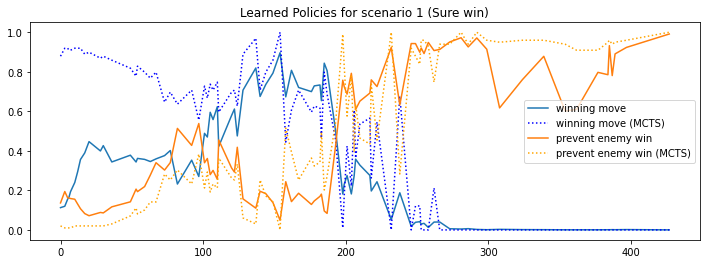

In [51]:
plt.figure(figsize=(12,4))
plt.title('Learned Policies for scenario 1 (Sure win)')
plt.plot(list(correct_move_probabilities.keys()), list(correct_move_probabilities.values()), label='winning move')
plt.plot(list(correct_move_probabilities_mcts.keys()), list(correct_move_probabilities_mcts.values()), label='winning move (MCTS)', linestyle=':', c='blue')
plt.plot(list(prevent_win_probabilities.keys()), list(prevent_win_probabilities.values()), label='prevent enemy win')
plt.plot(list(prevent_win_probabilities_mcts.keys()), list(prevent_win_probabilities_mcts.values()), label='prevent enemy win (MCTS)', linestyle=':', c='orange')
plt.legend()

plot_manager.save_current_plot("policies_scenario_1.pdf")
plt.show()

## 4.2 Prevent Sure win

In [57]:
state = game.new_initial_state()
state.apply_action(1)
state.apply_action(2)
state.apply_action(3)
state.apply_action(2)
state.apply_action(3)
state.apply_action(2)
print(state.observation_string())

.......
.......
.......
..o....
..ox...
.xox...



In [58]:
model.inference([state.observation_tensor()], [state.legal_actions_mask()])

[array([[0.51042384]], dtype=float32),
 array([[4.1253236e-03, 5.4301165e-02, 6.2300217e-01, 3.1775123e-01,
         4.5452971e-04, 1.9260294e-04, 1.7298997e-04]], dtype=float32)]

In [59]:
mcts_inference(game, model_0, state, uct_c=UCT_C, max_simulations=10000, temperature=temperature)

array([0.00240024, 0.00230023, 0.98369837, 0.00350035, 0.00280028,
       0.00290029, 0.00240024])

In [ ]:
%%capture
prevent_win_probabilities = dict()
prevent_win_probabilities_mcts = dict()
for iteration in model_manager.list_models():
    model_tmp = model_manager.load_model(iteration)
    policy = model_tmp.inference([state.observation_tensor()], [state.legal_actions_mask()])[1][0]
    policy_mcts = mcts_inference(game, model_tmp, state, uct_c=UCT_C, max_simulations=max_simulations, temperature=temperature)
    prevent_win_probabilities[iteration] = policy[2]
    prevent_win_probabilities_mcts[iteration] = policy_mcts[2]

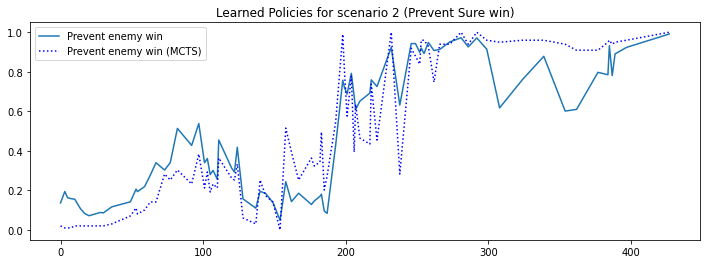

In [49]:
plt.figure(figsize=(12, 4))
plt.title('Learned Policies for scenario 2 (Prevent Sure win)')
plt.plot(list(prevent_win_probabilities.keys()), list(prevent_win_probabilities.values()), label='Prevent enemy win')
plt.plot(list(prevent_win_probabilities_mcts.keys()), list(prevent_win_probabilities_mcts.values()), label='Prevent enemy win (MCTS)', linestyle=':', c='blue')
plt.legend()

plot_manager.save_current_plot("policies_scenario_2.pdf")
plt.show()

## 4.3 Prevent Sure win next turn 

In [52]:
state = game.new_initial_state()
state.apply_action(3)
state.apply_action(3)
state.apply_action(2)
print(state.observation_string())

.......
.......
.......
.......
...o...
..xx...



In [ ]:
%%capture
correct_move_left_probabilities = dict()
correct_move_right_probabilities = dict()
correct_move_left_probabilities_mcts = dict()
correct_move_right_probabilities_mcts = dict()
for iteration in model_manager.list_models():
    model_tmp = model_manager.load_model(iteration)
    policy = model_tmp.inference([state.observation_tensor()], [state.legal_actions_mask()])[1][0]
    policy_mcts = mcts_inference(game, model_tmp, state, uct_c=UCT_C, max_simulations=max_simulations, temperature=temperature)
    correct_move_left_probabilities[iteration] = policy[1]
    correct_move_left_probabilities_mcts[iteration] = policy_mcts[1]
    correct_move_right_probabilities[iteration] = policy[4]
    correct_move_right_probabilities_mcts[iteration] = policy_mcts[4]

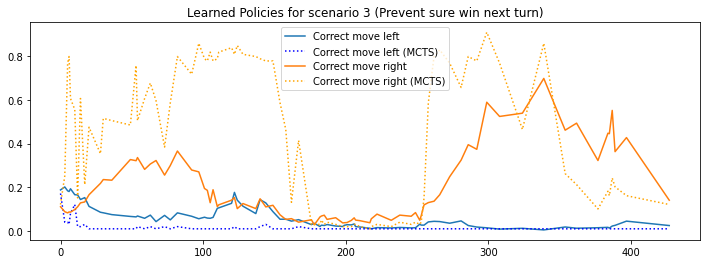

In [50]:
plt.figure(figsize=(12, 4))
plt.title('Learned Policies for scenario 3 (Prevent sure win next turn)')
plt.plot(list(correct_move_left_probabilities.keys()), list(correct_move_left_probabilities.values()), label='Correct move left')
plt.plot(list(correct_move_left_probabilities_mcts.keys()), list(correct_move_left_probabilities_mcts.values()), label='Correct move left (MCTS)', linestyle=':', c='blue')
plt.plot(list(correct_move_right_probabilities.keys()), list(correct_move_right_probabilities.values()), label='Correct move right')
plt.plot(list(correct_move_right_probabilities_mcts.keys()), list(correct_move_right_probabilities_mcts.values()), label='Correct move right (MCTS)', linestyle=':', c='orange')
plt.legend()

plot_manager.save_current_plot("policies_scenario_3.pdf")
plt.show()

### 4.3.1 Direct Inference

In [50]:
model.inference([state.observation_tensor()], [state.legal_actions_mask()])

[array([[0.295006]], dtype=float32),
 array([[0.10075048, 0.00504114, 0.16833879, 0.01341452, 0.6977839 ,
         0.00826976, 0.00640139]], dtype=float32)]

In [34]:
model_0.inference([state.observation_tensor()], [state.legal_actions_mask()])

[array([[-0.03895414]], dtype=float32),
 array([[0.12755336, 0.12457991, 0.14088295, 0.17892137, 0.16000627,
         0.14917813, 0.11887804]], dtype=float32)]

### 4.3.2 Using MCTS

In [56]:
mcts_inference(game, model, state, uct_c=UCT_C, max_simulations=max_simulations, temperature=temperature)

array([0.04040404, 0.01010101, 0.06060606, 0.01010101, 0.85858586,
       0.01010101, 0.01010101])

In [55]:
mcts_inference(game, model_0, state, uct_c=UCT_C, max_simulations=10000, temperature=temperature)

array([0.00770077, 0.02160216, 0.01320132, 0.01750175, 0.92269227,
       0.01090109, 0.00640064])

# 5. Play against previous generations

In [11]:
evaluation_manager = EvaluationManager(game, 100, mcts_config)

In [60]:
model_0 = model_manager.load_model(339)
model_1 = model_manager.load_model(0)
evaluation_results = evaluation_manager.compare_models(model_0, model_1)

INFO:tensorflow:Restoring parameters from /home/tobias/Uni/Semester Ma 5/Advanced Deep Learning for Robotics (IN2349)/Project/model_saves/connect_four/C4-13/checkpoint-339
INFO:tensorflow:Restoring parameters from /home/tobias/Uni/Semester Ma 5/Advanced Deep Learning for Robotics (IN2349)/Project/model_saves/connect_four/C4-13/checkpoint-0


In [13]:
print(f"Trained model won {1 - evaluation_results[0]:0.2%} of the games")

Trained model won 64.00% of the games
